# Research Question 5: 

## To what extend can future parliamentary compositions be predicted by economic and societal indicators?

## Overview
This part aims to predict the election outcomes using historical information after 1995 from various datasets.
We model two targets: 
 1. **Vote Share:** Percentage of votes received.
 2. **Vote Swing:** Change in the vote share from the last election.

## Methodology 
*   **Feature Engineering:** We use lagged freatures, and for important variables delta and rolling mean to capture historic changes and trends.
*   **Validation:** We use a **Walk-Forward Validation**  to prevent data leakage and recreate forecasting.
*   **Models:** We compare a Persistence Baseline against Random Forest and LightGBM regressors. The other models were discarded as the performed significantly worse.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

In [ ]:
PATH_ROOT = Path.cwd().parent
PATH_DATA = PATH_ROOT / "data"
PATH_DF = PATH_DATA / "merged_df.csv"

In [ ]:
df_merged = pd.read_csv(PATH_MERGED, sep=",", parse_dates=["election_date"])
df = df_merged.loc[df_merged["year"] >= 1995].copy()
df = df.sort_values(["geo", "party_code", "election_date", "year"]).reset_index(drop=True)
df.head()

,geo,year,country,election_date,party_name,vote_share_percent,party_code,parfam,right_left_position,planned_economy,...,"Less than primary, primary and lower secondary education (levels 0-2)",Tertiary education (levels 5-8),Upper secondary and post-secondary non-tertiary education (levels 3 and 4),"Upper secondary, post-secondary non-tertiary and tertiary education (levels 3-8)",migration_inflow,median_age,population_total,urban_population_pct,wealth_top10_share,rel_migration
0,AT,1995,Austria,1995-12-17,The Greens,4.815,42110,10.0,19.658,0.855,...,33.6,6.7,59.7,66.4,NaN,36.1,7948278.0,66.110930,0.6066,NaN
1,AT,1996,Austria,1995-12-17,The Greens,4.815,42110,10.0,19.658,0.855,...,32.3,6.9,60.8,67.7,69930.0,36.5,7959017.0,66.327497,0.6068,0.008786
2,AT,1997,Austria,1995-12-17,The Greens,4.815,42110,10.0,19.658,0.855,...,30.2,7.0,62.8,69.8,70122.0,36.8,7968041.0,66.510675,0.6072,0.008800
3,AT,1998,Austria,1995-12-17,The Greens,4.815,42110,10.0,19.658,0.855,...,29.8,7.0,63.3,70.2,72723.0,37.2,7976789.0,66.658505,0.6076,0.009117
4,AT,1999,Austria,1999-10-03,The Greens,7.400,42110,10.0,-15.102,2.245,...,29.3,12.3,58.5,70.7,86710.0,37.5,7992324.0,66.769024,0.6093,0.010849


### Feature Configuration
We categorize our features to apply appropriate preprocessing:
* **Numeric Lags:** Economic indicators which influence voter sentiment.
* **Log Transforms:** Variables which need normalization 
* **Categorical:** To get the the model to learn party family specific  (e.g., Green parties might behave differently than Conservatives).

In [ ]:
log_cols = [
    "population_total",
    "gdp_per_cap"
    ]

numeric_lag_cols = [
    "vote_share_percent",
    "consumer_prices",
    "f_unemployment",
    "m_unemployment",
    "t_unemployment",
    "dependency_ratio_15_64",
    "debt_to_gdp",
    "total_poverty",
    "migration_inflow",
    "median_age",
    "urban_population_pct",
    "wealth_top10_share",
    "rel_migration", 
    "log_gdp_per_cap",
    "log_population_total"]


categorical_cols = [
    "geo",
    "parfam"]

party_cols = [
    "right_left_position",
    "planned_economy",
    "welfare_state",
    "market_economy",
    "inter_positive",
    "democracy",
    "sustainability_positive"]

In [5]:
for col in log_cols:
    df[f"log_{col}"] = np.log1p(df[col].clip(lower=0))
    
for col in categorical_cols:
    df[col] = df[col].astype("category")

### Feature Engineering: 
Since elections are time-series events, the most powerful predictors are past performance. We define a custom function to create:
1.  **Lagged Features:** The value of the feature in the *previous* election.
2.  **Delta:** The change of the last two periods.
3.  **Rolling Means (3-period):** An average of the last 3 elections to capture trends and reduce noise from outlier years.
4.  **Vote Swing:** Calculated as $Vote_{current} - Vote_{previous}$. This represents the *momentum* of a party.

In [ ]:
high_impact_cols = ["vote_share_percent", "consumer_prices", "migration_inflow", "log_gdp_per_cap"]


def add_features(df, group_cols, all_cols, impact_cols):
    df = df.copy()
    annual_group = df.groupby(group_cols, observed=True)
    
    # Vote-share Grouping
    is_new_election = df["election_date"] != annual_group["election_date"].shift(1)
    election_subset = df[is_new_election].copy()
    vote_group = election_subset.groupby(group_cols, observed=True)

    for col in [c for c in all_cols if c != "vote_share_percent"]:
       
        df[f"{col}_lag1"] = annual_group[col].shift(1)
        
        if col in impact_cols:
            df[f"{col}_delta_1y"] = df[f"{col}_lag1"] - annual_group[col].shift(2)

   
    col = "vote_share_percent"
    election_subset[f"{col}_lag1"] = vote_group[col].shift(1)
    election_subset[f"{col}_rolling_3elec"] = (
        vote_group[col]
        .shift(1)
        .rolling(window=3, min_periods=1)
        .mean()
    )
    
    # Merge the election-based features back into main dataframe
    cols_to_merge = group_cols + ["election_date", f"{col}_lag1", f"{col}_rolling_3elec"]
    df = df.merge(election_subset[cols_to_merge], on=group_cols + ["election_date"], how="left")
    df["vote_swing"] = df["vote_share_percent"] - df["vote_share_percent_lag1"]
    return df

df_features = add_features(df, ["geo", "party_code"], numeric_lag_cols, high_impact_cols)
df_features.head(20)

,geo,year,country,election_date,party_name,vote_share_percent,party_code,parfam,right_left_position,planned_economy,...,gdp_per_cap_delta_1y,migration_inflow_lag1,migration_inflow_delta_1y,median_age_lag1,urban_population_pct_lag1,wealth_top10_share_lag1,rel_migration_lag1,vote_share_percent_lag1,vote_share_percent_rolling_3elec,vote_swing
0,AT,1995,Austria,1995-12-17,The Greens,4.815,42110,10.0,19.658,0.855,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT,1996,Austria,1995-12-17,The Greens,4.815,42110,10.0,19.658,0.855,...,NaN,NaN,NaN,36.1,66.110930,0.6066,NaN,NaN,NaN,NaN
2,AT,1997,Austria,1995-12-17,The Greens,4.815,42110,10.0,19.658,0.855,...,-0.047696,69930.0,NaN,36.5,66.327497,0.6068,0.008786,NaN,NaN,NaN
3,AT,1998,Austria,1995-12-17,The Greens,4.815,42110,10.0,19.658,0.855,...,1.349229,70122.0,192.0,36.8,66.510675,0.6072,0.008800,NaN,NaN,NaN
4,AT,1999,Austria,1999-10-03,The Greens,7.400,42110,10.0,-15.102,2.245,...,0.180857,72723.0,2601.0,37.2,66.658505,0.6076,0.009117,4.815,4.815000,2.585
5,AT,2000,Austria,1999-10-03,The Greens,7.400,42110,10.0,-15.102,2.245,...,-0.618554,86710.0,13987.0,37.5,66.769024,0.6093,0.010849,4.815,4.815000,2.585
6,AT,2001,Austria,1999-10-03,The Greens,7.400,42110,10.0,-15.102,2.245,...,-2.011797,81676.0,-5034.0,37.9,66.840816,0.6076,0.010195,4.815,4.815000,2.585
7,AT,2002,Austria,2002-11-24,The Greens,9.470,42110,10.0,-20.876,2.336,...,0.056424,89928.0,8252.0,38.3,66.888746,0.6070,0.011182,7.400,6.107500,2.070
8,AT,2003,Austria,2002-11-24,The Greens,9.470,42110,10.0,-20.876,2.336,...,-0.336243,108125.0,18197.0,38.8,66.926357,0.6075,0.013379,7.400,6.107500,2.070
9,AT,2004,Austria,2002-11-24,The Greens,9.470,42110,10.0,-20.876,2.336,...,1.280829,111869.0,3744.0,39.1,66.955861,0.6081,0.013775,7.400,6.107500,2.070


In [7]:
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [15, 31, 50],
    'model__max_depth': [-1, 5, 10],
    'model__min_child_samples': [5, 10, 20] 
}

tscv = TimeSeriesSplit(n_splits=5)

# Part 1: Predicting Absolute Vote Share

### Data Preparation
We drop rows where the previous vote share is missing (e.g., first election) because autoregressive features are our strongest predictors.

### Walk-Forward Validation 
Standard Cross-Validation (K-Fold) is dangerous here because it creates "future leakage".
Instead, we define a **Testing Period of the last 5 years**. We will train on all history prior to a specific year and test on that year, simulating a real forecast.

In [8]:
df_model = df_features.dropna(subset=["vote_share_percent_lag1"]).copy()

cols_drop = ["country", "party_name", "party_code", "parfam_label", "vote_swing"]

# Drop duplicates based on the specific combination
df_model = df_model.drop_duplicates(
    subset=["geo", "party_code", "election_date"], 
    keep='first'
).drop(columns=cols_drop)

# Define the Testing Period (Last 5 Years)
years = sorted(df_model["year"].unique())
test_years = years[-5:]
tuning_cutoff_year = test_years[0]  

print(f"Tuning on data before: {tuning_cutoff_year}")
print(f"Testing on years: {test_years}")

Tuning on data before: 2019
Testing on years: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


### Model Pipelines
We construct a machine learning pipeline:
1.  **Preprocessing:** `OrdinalEncoder` converts categorical text (like 'Austria') into numbers the model can use.
2.  **Imputation:** `SimpleImputer` fills missing economic data with medians, ensuring the model doesn't crash on patchy data.
3.  **Regressors:**
    * **Random Forest:** Good at capturing complex, non-linear interactions without heavy tuning.
    * **LightGBM:** A gradient boosting model that is generally faster and often more accurate for tabular data.

We perform a **Grid Search** on the LightGBM model to find the best `learning_rate` and tree depth.

In [9]:
target_col = "vote_share_percent"
engineered_features = [c for c in df_model.columns if "_lag" in c or "_delta" in c or "_rolling_3" in c or "log_" in c]
all_features = engineered_features + categorical_cols + party_cols + ["year"]

df_sorted = df_model.sort_values("election_date")
X = df_sorted[all_features]
y = df_sorted[target_col]

# Split Data for Tuning
mask_tuning = df_sorted["year"] < tuning_cutoff_year

X_tuning = X[mask_tuning]
y_tuning = y[mask_tuning]

In [ ]:
# Absolute Pipeline
sklearn.set_config(transform_output="pandas")
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ], 
    remainder='passthrough' 
)

def get_pipeline(model):
    return Pipeline([
        ("prep", preprocessor),
        ("impute", SimpleImputer(strategy='median')), # Ensures no NAs reach RF
        ("model", model)
    ])

rf_pipeline_share = get_pipeline(RandomForestRegressor(n_estimators=400, max_depth=6, random_state=42, n_jobs=-1))
lgbm_pipeline_share = get_pipeline(LGBMRegressor(random_state=42, verbose=-1))


In [11]:
grid_search = GridSearchCV(
    estimator=lgbm_pipeline_share,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    refit=False,
    n_jobs=-1,
    verbose=0
)

# Fit Grid Search
grid_search.fit(X_tuning, y_tuning)

# Final parameters used
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")


Best parameters found: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_samples': 5, 'model__n_estimators': 500, 'model__num_leaves': 15}


In [12]:
# Apply best_params to the pipeline
lgbm_pipeline_share.set_params(**best_params)

,steps,"[('prep', ...), ('imputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Walk-Forward Evaluation
We iterate through the test years and evaluate three approaches:
1.  **Baseline:** Persistence model. We predict the party will get the same share as the last election.
2.  **Random Forest:** Trained on all data prior to the test year.
3.  **LightGBM (Tuned):** Trained on all data prior to the test year.

**Success Metric:** We look for models with a lower **MAE** and **RMSE** than the Baseline. If our model beats the baseline, it means our economic/social features are explaining changes.

In [13]:
results = []

for test_year in test_years:
    train_mask = df_sorted["year"] < test_year
    test_mask = df_sorted["year"] == test_year

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    # Get Results of baseline 
    baseline_mae = mean_absolute_error(y_test, X_test["vote_share_percent_lag1"])
    baseline_rmse = np.sqrt(mean_squared_error(y_test, X_test["vote_share_percent_lag1"]))
    results.append({
        "model": "Baseline", 
        "test_year": test_year, 
        "MAE": baseline_mae, 
        "RMSE": baseline_rmse
    })

    # RandomForest fit and results
    rf_pipeline_share.fit(X_train, y_train)
    rf_preds = np.clip(rf_pipeline_share.predict(X_test), 0, 100)
    
    rf_mae = mean_absolute_error(y_test, rf_preds)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
    results.append({
        "model": "RandomForest", 
        "test_year": test_year, 
        "MAE": rf_mae, 
        "RMSE": rf_rmse
    })

    # LightGBM fit and results
    lgbm_pipeline_share.fit(X_train, y_train)
    lgbm_preds = np.clip(lgbm_pipeline_share.predict(X_test), 0, 100)
    
    lgbm_mae = mean_absolute_error(y_test, lgbm_preds)
    lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_preds))
    results.append({
        "model": "LightGBM (Tuned)", 
        "test_year": test_year, 
        "MAE": lgbm_mae, 
        "RMSE": lgbm_rmse
    })

# Summary Output
results_df = pd.DataFrame(results)

# Get best results 
summary = results_df.groupby("model")[["MAE", "RMSE"]].mean().sort_values("MAE")

print("\n Performance Summary")
print(summary)


 Performance Summary
                       MAE      RMSE
model                               
Baseline          3.065650  4.481388
RandomForest      3.734161  4.970968
LightGBM (Tuned)  3.820238  5.042277


# Part 2: Predicting Vote Swing

Because of the results in the Absolute Votes Prediction we added another target, as the votes shares are often dominated by the voters that always make the same choice.
**Swing** tries to isolate the *volatility*. Predicting swing allows us to capture the *direction* of public sentiment shifts driven by current events.

We repeat the feature engineering and cleaning process, specifically targeting the `vote_swing` variable.

In [14]:
df_proc = df_features.dropna(subset=["vote_swing"])

cols_drop = ["country", "party_name", "party_code", "parfam_label"]

# Drop duplicates based on the specific combination
df_proc = df_proc.drop_duplicates(
    subset=["geo", "party_code", "election_date"], 
    keep='first'
).drop(columns=cols_drop)

# Define the Testing Period (Last 5 Years)
years = sorted(df_proc["year"].unique())
test_years = years[-5:]
tuning_cutoff_year = test_years[0]  

print(f"Tuning on data before: {tuning_cutoff_year}")
print(f"Testing on years: {test_years}")


Tuning on data before: 2019
Testing on years: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


In [15]:
target_col_swing = "vote_swing"
engineered_features = [c for c in df_proc.columns if any(s in c for s in ["_lag", "_rolling_3", "_delta", "log_"])]
all_features = engineered_features + categorical_cols + party_cols + ["year"]

df_sorted_swing = df_proc.sort_values("election_date")
X_swing = df_sorted_swing[all_features]
y_swing = df_sorted_swing[target_col_swing] 
#y_actual = df_sorted_swing[target_col] 

# Split Data for Tuning 
mask_tuning = df_sorted_swing["year"] < tuning_cutoff_year
X_tuning_swing = X_swing[mask_tuning]
y_tuning_swing = y_swing[mask_tuning]


### Tuning the Swing Model
Swing is a noisier target than absolute share. Thats why we re-tune our LightGBM model specifically for this distribution.

In [16]:
# Swing models pipeline
preprocessor = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
], remainder='passthrough')

def get_pipeline(model):
    return Pipeline([
        ("prep", preprocessor),
        ("impute", SimpleImputer(strategy='median')),
        ("model", model)
    ])

rf_pipeline_swing = get_pipeline(RandomForestRegressor(n_estimators=400, max_depth=6, random_state=42))
lgbm_pipeline_swing = get_pipeline(LGBMRegressor(n_estimators=500, learning_rate=0.03, random_state=42, verbose=-1))


In [17]:
grid_search_swing = GridSearchCV(
    estimator=lgbm_pipeline_swing,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    refit=False,
    n_jobs=-1,
    verbose=0
)

# Fit Grid Search
grid_search_swing.fit(X_tuning_swing, y_tuning_swing)

# Final parameters used
best_params_swing = grid_search_swing.best_params_
print(f"Best parameters found: {best_params_swing}")


Best parameters found: {'model__learning_rate': 0.01, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 100, 'model__num_leaves': 31}


In [18]:
# Apply best_params to the pipeline
lgbm_pipeline_swing.set_params(**best_params_swing)

,steps,"[('prep', ...), ('impute', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Swing evaluation
Walk-forward by test year: train on prior years, compare a persistence baseline (last vote share) to RF and LightGBM swing models that add predicted swing back to the last result.

In [ ]:
# Swing evaluation loop
results_swing = []

for test_year in test_years:
    train_mask = df_sorted_swing["year"] < test_year
    test_mask = df_sorted_swing["year"] == test_year

    X_train_swing, y_train_swing = X_swing[train_mask], y_swing[train_mask]
    X_test_swing, y_test_swing = X_swing[test_mask], y_swing[test_mask]

    # Baseline 
    # The baseline for swing is predicting 0 
    baseline_preds_swing = np.zeros(len(y_test_swing))
    
    baseline_mae = mean_absolute_error(y_test_swing, baseline_preds_swing)
    baseline_rmse = np.sqrt(mean_squared_error(y_test_swing, baseline_preds_swing))
    results_swing.append({
        "model": "Baseline", 
        "test_year": test_year, 
        "MAE": baseline_mae, 
        "RMSE": baseline_rmse
    })

    # RandomForest
    rf_pipeline_swing.fit(X_train_swing, y_train_swing)
    rf_preds_swing = np.clip(rf_pipeline_swing.predict(X_test_swing), -50, 50)
    
    rf_mae = mean_absolute_error(y_test_swing, rf_preds_swing)
    rf_rmse = np.sqrt(mean_squared_error(y_test_swing, rf_preds_swing))
    results_swing.append({
        "model": "RandomForest", 
        "test_year": test_year, 
        "MAE": rf_mae, 
        "RMSE": rf_rmse
    })

    #  LightGBM 
    lgbm_pipeline_swing.fit(X_train_swing, y_train_swing)
    lgbm_preds_swing = np.clip(lgbm_pipeline_swing.predict(X_test_swing), -50, 50)
    
    lgbm_mae = mean_absolute_error(y_test_swing, lgbm_preds_swing)
    lgbm_rmse = np.sqrt(mean_squared_error(y_test_swing, lgbm_preds_swing))
    results_swing.append({
        "model": "LightGBM (Tuned)", 
        "test_year": test_year, 
        "MAE": lgbm_mae, 
        "RMSE": lgbm_rmse
    })

# Summary Output
results_df_swing = pd.DataFrame(results_swing)

# Get best results 
summary_swing = results_df_swing.groupby("model")[["MAE", "RMSE"]].mean().sort_values("MAE")

print("\n--- Swing Model Performance Summary ---")
print(summary_swing)


--- Swing Model Performance Summary ---
                       MAE      RMSE
model                               
Baseline          3.065650  4.481388
LightGBM (Tuned)  3.306609  4.507134
RandomForest      3.676294  4.842765


### Feature Importance Analysis
Finally, we visualize what drives our models.
* **Autoregression:** For the Absolute model, `vote_share_lag1` will likely be the dominant feature (past predicts future).
* **Macro Drivers:** For the Swing model, we look for features like `consumer_prices_delta` (inflation change) or `migration_inflow`. These tell us why a party gained or lost votes, moving beyond simple history.

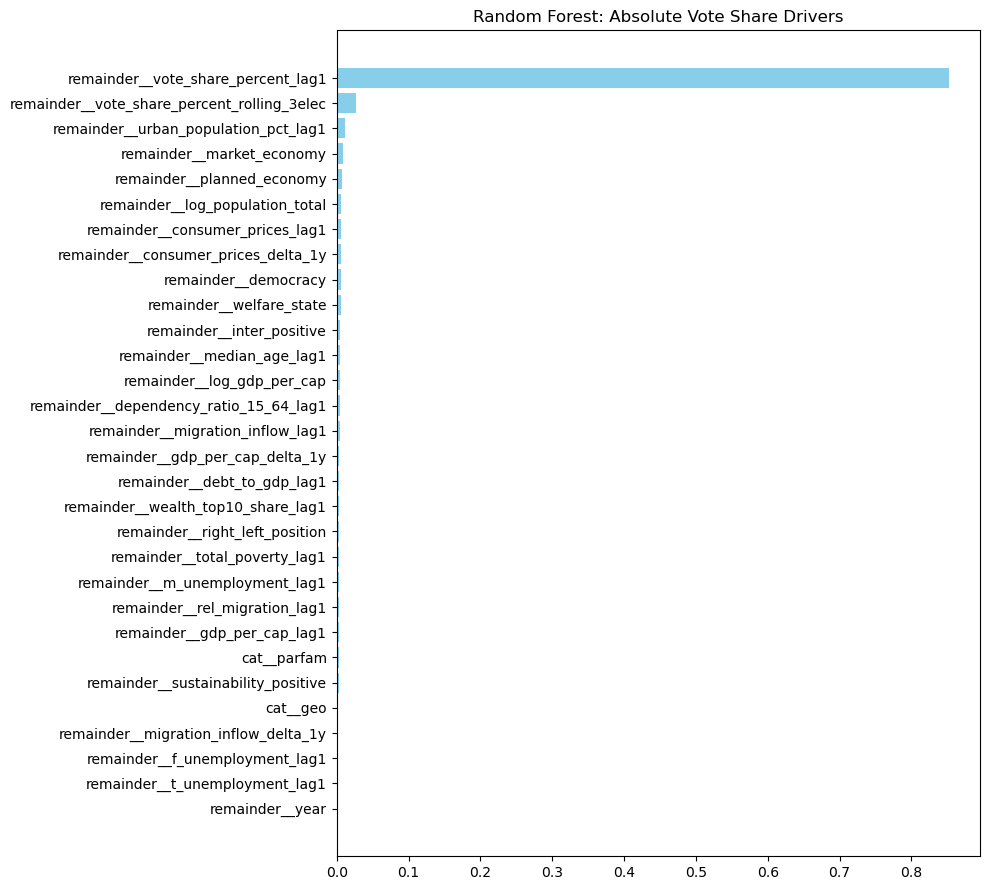

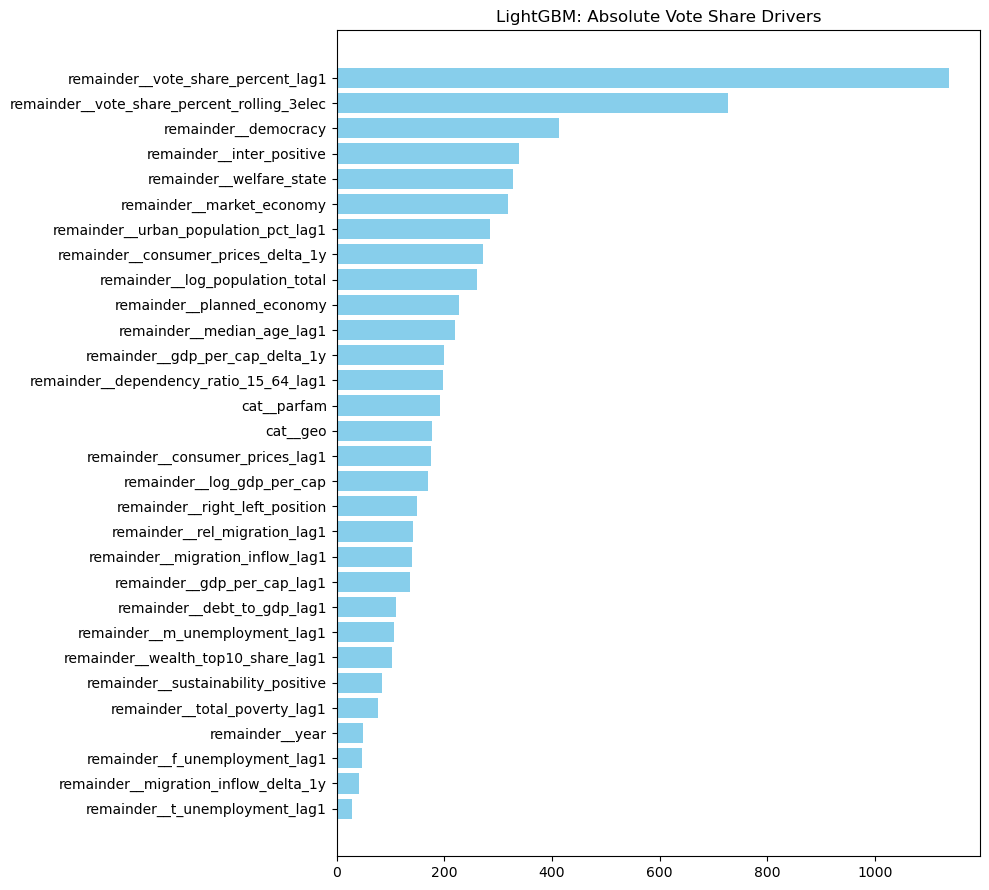

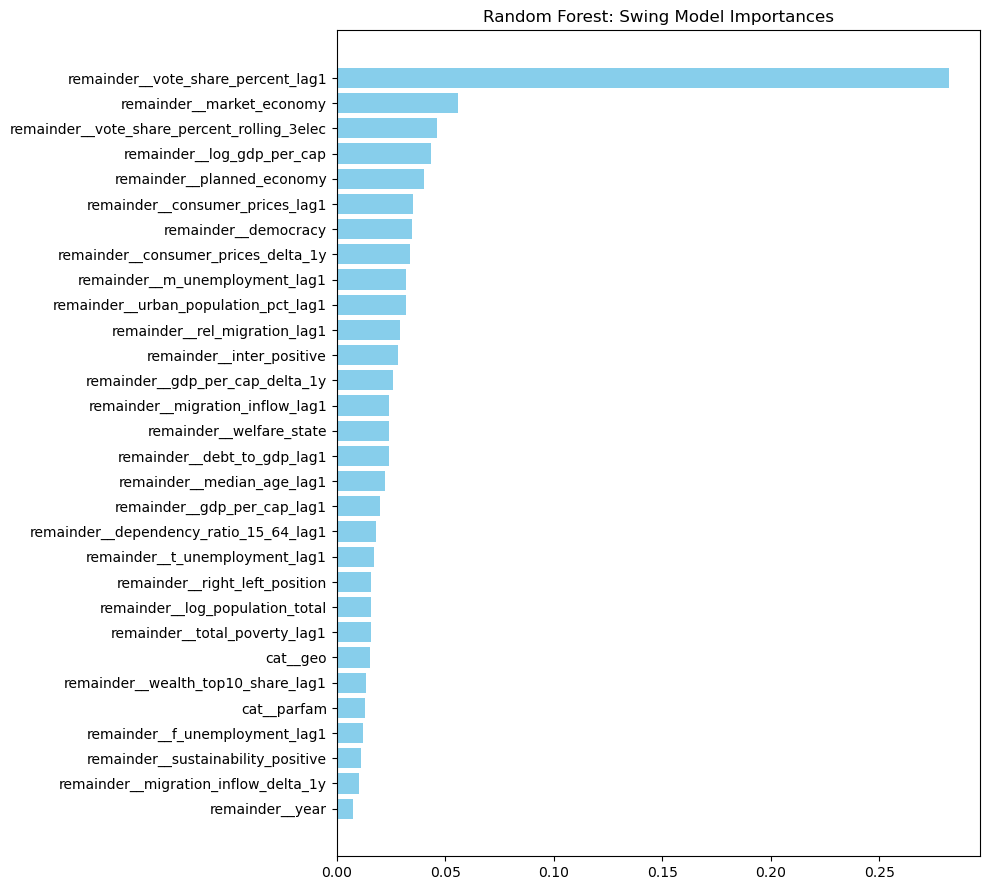

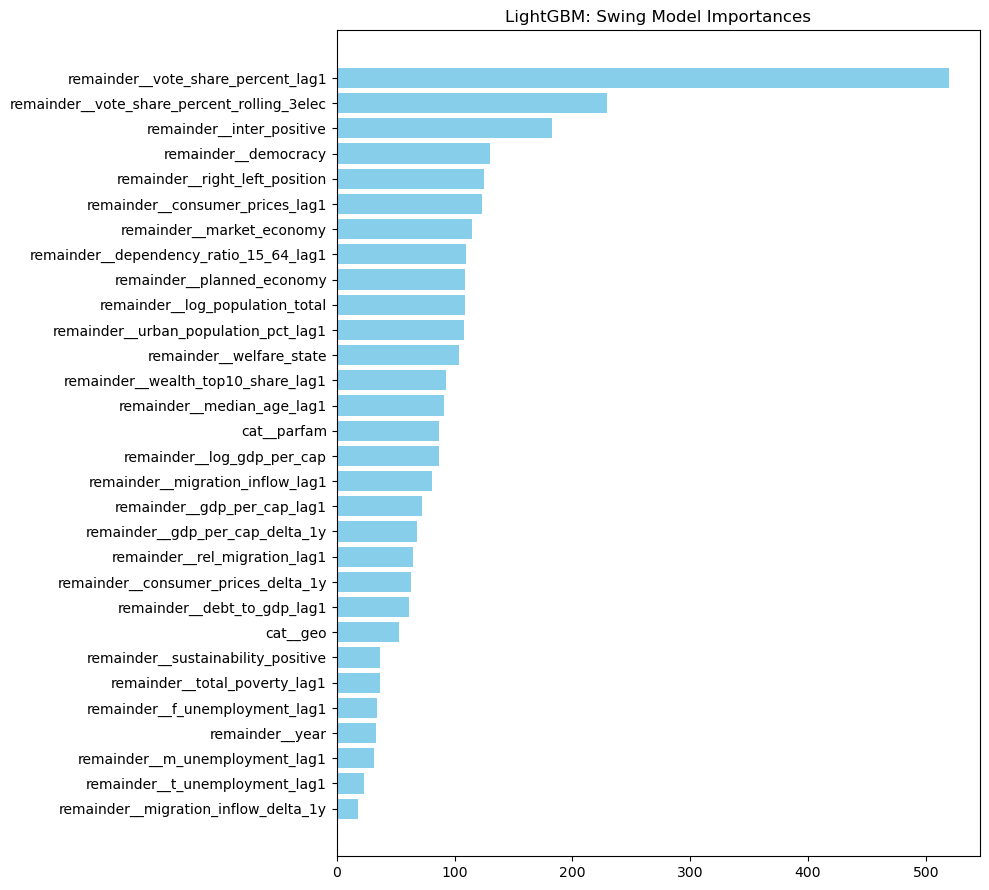

In [20]:

def plot_pipeline_importance(pipeline, title="Feature Importance"):
    model = pipeline.steps[-1][1]
    
    try:
        feature_names = pipeline.named_steps['prep'].get_feature_names_out()
    except:
        feature_names = all_features 

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        return

    feat_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, len(feat_df)//4 + 2))
    plt.barh(feat_df['feature'], feat_df['importance'], color='skyblue')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
# Absolute vote share
plot_pipeline_importance(rf_pipeline_share, title="Random Forest: Absolute Vote Share Drivers")
plot_pipeline_importance(lgbm_pipeline_share, title="LightGBM: Absolute Vote Share Drivers")

# Swing share
plot_pipeline_importance(rf_pipeline_swing, title="Random Forest: Swing Model Importances")
plot_pipeline_importance(lgbm_pipeline_swing, title="LightGBM: Swing Model Importances")


## Key Findings
1.  In both Absolute Share and Swing models, the Persistence Baseline outperformed the machine learning models. The Baseline achieved an MAE of ~3.07, while the best ML model (LightGBM) lagged behind at ~3.31.

2. The plots show that the previous election result is the most powerful predictor. Macro-economic indicators like GDP growth and inflation, are relevant, but show significantly lower prediction power.

3. The Swing Model showed more adaptability, which suggests that ML is better suited for predicting movement rather than levels in vote prediction.

### Analysis
The underperformance of the ML models to the baseline highlights two main factors:

1. The Voter behavior in the dataset is quite stable. Most economic factors only affects a small margin of swing voters, making it hard for models to justify changing the prediction from the previous result without causing higher errors.

2. Out current models still lack Context. Economic growth typically rewards the party in power but does not affect opposition parties the same way. Without an "in-government" flag, the models likely treat economic growth as a universal benefit, which is theoretically and empirically incorrect. 

### Future Improvements
To surpass the persistence baseline, future iterations should:

* Add Interaction Terms: Link economic performance to the Incumbent Party.
* Incorporate Polling: Add the most recent poll data as a feature to capture short-term shifts.
* Normalization: Constrain predictions to ensure party shares sum to 100% per election.